In [1]:
import battery_parser as bp
import os
import pandas as pd
import numpy as np
import re
import copy
import itertools
import matplotlib.pyplot as plt

In [2]:
root_dir  = r'D:\!Science\Физтех\Циклирования\Результаты'
file_statistic_path = os.path.join(root_dir, r'File_statistics.csv')
file_statistic = bp.exporting.load_experiment(file_statistic_path)


In [3]:
statistic_dir = os.path.join(root_dir, r'Статистика')
statistics = {}
for step in range(5, 6):
    for pouch, _ in file_statistic[file_statistic['Step_id']==step].groupby('ID'):
        statistics_path = os.path.join(statistic_dir,fr'{step}',fr'{pouch}.csv' )
        statistics[pouch] = bp.exporting.load_experiment(statistics_path, parse_dates = ['Datetime_min', 'Datetime_max'])


In [4]:
borders = {'LFP':[2.51,3.64, 280.0], 'NMC':[2.51, 4.19, 195.0],'LTO':[1.51, 2.84, 102.0]}

In [5]:
class Check_pattern:  # TODO перенести в файл с обработкой (который будет)
    """
    Creates object that checks if given value list/dataframe corresponds to given pattern.
    Pattern engine use slicing window with size equal to pattern length. Each pattern element is dict in form {'column_name':(compare operation, value)} for one condition per column or {'column_name':[(compare operation1, value1), (compare operation2, value2)]} for multiple conditions for the column.
    Args:
        pattern:
    """

    def __init__(self, pattern:list, ):
        self.length = len(pattern)
        self.pattern = [self.transform_pattern(step) for step in pattern]


    def __call__(self, split: pd.DataFrame):
        """
        Checks if values in list are consistent with pattern. List length should be
        equal to pattern length.
        Args:
            split (): list of values.

        Returns:

        """
        assert len(self.pattern) == len(split)
        checks = []
        for series, conditions in zip(split.reset_index(drop=True).iterrows(), self.pattern):
            check = self.check_series(series[1], conditions)
            if not check:
                return False
            checks.append(check)
        return all(checks)

    def __len__(self):
        return len(self.pattern)

    @staticmethod
    def transform_pattern(step):
        if isinstance(step, list):
            return step
        step_transform = []
        for key in step.keys():
            if len(step[key]) > 1 and isinstance(step[key], list):
                step_transform.extend([(key, *comparator ) for comparator in step[key]])
            else:
                step_transform.append((key, *step[key]))
        return step_transform


    def check_series(self, series, conditions):
        results = []
        for column, operator, value in conditions:
            result = self.check_condition(a=series[column], b=value, operation=operator)
            if not result:
                return False
            results.append(result)
        return all(results)

    @staticmethod
    def check_condition(a, b, operation):
        match operation:
            case 'less':
                return a < b
            case 'more':
                return a > b
            case 'equal':
                return a == b
            case 'contain':
                return b in a
            case 'approx':
                borders = [b*0.98, b*1.02]
                borders.sort()
                return (a >= borders[0]) and (a <= borders[1])


def window_slider(window_size, stat_data):
    len_data = len(stat_data)
    for i in range(len_data-window_size+1):
        yield i, i+window_size

def find_pattern(statistics: pd.DataFrame, pattern: list):
    pattern_checker = Check_pattern(pattern)
    window_size = len(pattern_checker)

    slices = window_slider(window_size, statistics)
    roll = {statistics.iloc[a].name:True for a, b in slices if pattern_checker(statistics.iloc[a:b])}
    roll = pd.DataFrame.from_dict(roll, 'index', columns=['result'])
    windows = []
    for i in roll[roll['result']].index:
        start_index = i
        end_index =  start_index + window_size
        windows.append(list(range(start_index, end_index)))
    return windows



In [6]:
class Pattern_dict:

    def __init__(self, e_min, e_max, p_max, duration_column='Time_range'):
        self._e_min = e_min
        self._e_max = e_max
        self._p_max = p_max
        self._p = {}
        self.duration_column = duration_column
        self._create_pattern()
        self._create_dst()

    def __getitem__(self, item):
        return self._p[item]

    def __setitem__(self, key, value):
        self._p[key] = value

    def set_duration(self, seconds):
        return [(self.duration_column, 'equal', seconds)]

    def _create_pattern(self):
        self._p.update(
            {
                'discharge':[('Step Type','contain', ' dchg')],
                'charge':[('Step Type','contain', ' chg')],
                'rest':[('Step Type','contain', 'rest')]
             }
                       )


        self._p.update(
            {
            'discharge_full':self._p['discharge']+[('E_last', 'less', self._e_min)],
            'charge_full':self._p['charge']+[('E_last', 'more',self._e_max)]
            }
        )

    def _create_dst(self):
        power_percent = [0.0, 0.125, 0.25, -0.125, 0.0,
                            0.125, 0.25, -0.125, 0.0, 0.125,
                            0.25, -0.125, 0.0, 0.125, 1.0,
                            0.625, -0.25, 0.25, -0.5, 0.0]
        power = [i*self._p_max for i in power_percent]
        time_a = [16,28,12,8,16,
                    24,12,8,16,24,
                    12,8,16,36,8,
                    24,8,32,8,44]
        time_b = [16,28,12,8,16,
                    24,12,8,16,24,
                    12,8,16,36,8,
                    120,8,32,8,44]
        dst_all = []
        for i in power:
            if i>0:
                step='cp dchg'
            elif i < 0:
                step = 'cp chg'
            elif i == 0:
                step = 'rest'
            one_move = [('Step Type', 'contain', step), ('P_mean','approx', -i)]
            if i == 0:
                one_move = [('Step Type', 'contain', step)]
            dst_all.append(one_move)

        dst_b = []
        for step, time in zip(dst_all, time_b):
            times = self.set_duration(time)
            dst_b.append(step+times)

        dst_a = []
        for step, time in zip(dst_all, time_a):
            times = self.set_duration(time)
            dst_a.append(step+times)
        self._p.update({'dst_all':dst_all, 'dst_a':dst_a, 'dst_b':dst_b})


In [7]:
def extract_patterns(data, patterns):
    slices = []
    for pattern in patterns:
        windows = find_pattern(data, pattern)
        selection = windows[0]
        slices.append(data.loc[selection])
        data = data.loc[selection[-1]+1:]
    slices.append(data)
    return slices

def extract_dst(data, borders):
    slices = extract_patterns(data, borders)
    start = slices[0].index[0]+1
    finish = slices[1].index[0]
    return [data.loc[start:finish], data.loc[finish+1:]]

def extract_ic(data, pattern):
    composition = []
    for i in find_pattern(data, pattern):
        composition.extend(i)
    return [data.loc[composition], data.loc[composition[-1]+1:]]

def extract_chemistry(pouch):
    return re.findall(r'([A-Z]{3})', pouch)[0]

In [8]:
def extract_slices(statistics, pouch):
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    patterns = [[p['discharge_full'],
                p['rest'],
                p['charge_full'],
                p['discharge_full']],

                [p['rest']+p.set_duration(120*60),
                p['discharge']+p.set_duration(10),
                p['rest']+p.set_duration(60*60)],

                [p['discharge']+p.set_duration(30),
                 p['discharge']+p.set_duration(5)],


                ]
    dst_borders =   [[p['charge_full']],
                [p['discharge_full']]]

    pattern_cc_ic = [[p['rest'],
                     p['discharge_full'],
                    p['rest'],
                    p['charge_full']]]

    patterns_ic = [[p['discharge'],
                  p['rest']+p.set_duration(90*60)],

                 [p['discharge'],
                  p['rest']+p.set_duration(180*60)]
                 ]
    slices = extract_patterns(statistics, patterns)
    steps = slices[:3]
    slices = extract_dst(slices[-1], dst_borders)
    steps.append(slices[0])
    slices = extract_patterns(slices[-1], pattern_cc_ic)
    steps.append(slices[0])
    slices = extract_ic(slices[-1], patterns_ic[0])
    steps.append(slices[0])
    slices = extract_ic(slices[-1], patterns_ic[1])
    steps.append(slices[0])
    return steps

In [9]:
def process_1(step):
    processing1 = {}

    discharge_step = step[step['Step Type'].str.contains(' dchg')].iloc[-1]
    charge_step = step[step['Step Type'].str.contains(' chg')].iloc[-1]
    processing1['Q_dchg'] = discharge_step['Q_max']
    processing1['Q_chg'] = charge_step['Q_max']
    processing1['En_dchg'] = discharge_step['Energy_max']
    processing1['En_chg'] = charge_step['Energy_max']
    processing1['Time_start'] = step['Datetime_min'].min()
    processing1['T_mean'] = step['T_mean'].mean()
    processing1['T_max'] = step['T_max'].max()

    return processing1

def process_2(step):
    processing = {}
    discharge_step = step[step['Step Type'].str.contains(' dchg')].iloc[-1]
    processing['P'] = discharge_step['P_last']
    processing['T2_max'] =  step['T_max'].max()
    return processing

def process_3(step):
    processing = {}
    processing['R'] = (step['E_last'].iloc[0]- step['E_last'].iloc[1])/(step['I_mean'].iloc[0]- step['I_mean'].iloc[1])
    return processing

def process_4(step, pouch):
    processing = {}
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    if np.isin(step['Step Type'].unique() ,['cp dchg', 'cp chg', 'rest']).all():
        print('Fully dst')
    processing['Qdch_dst'] = -step[step['Step Type']== 'cp dchg']['Net Q'].sum()
    processing['En_dch_dst'] = -step[step['Step Type']== 'cp dchg']['Net Energy'].sum()
    processing['Qch_dst'] = step[step['Step Type']== 'cp chg']['Net Q'].sum()
    processing['En_ch_dst'] = step[step['Step Type']== 'cp chg']['Net Energy'].sum()
    processing['Q_dst'] = processing['Qdch_dst']-processing['Qch_dst']
    processing['n_dst_all'] = len(find_pattern(step, p['dst_all']))
    processing['n_dst_b'] = len(find_pattern(step, p['dst_b']))
    processing['n_dst_a'] = len(find_pattern(step, p['dst_a']))
    processing['T_mean_dst'] = step['T_mean'].mean()
    processing['T_max_dst'] = step['T_max'].max()
    if processing['n_dst_b']:
        last_idx = find_pattern(step, p['dst_b'])[0][0]
        processing['n_dst_a_before_b'] = len(find_pattern(step.loc[:last_idx], p['dst_a']))
    return processing

def process_5(step):
    processing = {}
    discharge_step = step[step['Step Type'].str.contains(' dchg')].iloc[-1]
    charge_step = step[step['Step Type'].str.contains(' chg')].iloc[-1]
    processing['Idch_ic'] = discharge_step['I_mean']
    processing['Ich_ic'] = charge_step['I_mean']
    return processing

def process_6(step, pattern):
    processing = {}
    processing['n_IC1'] = len(find_pattern(step, pattern=pattern))
    return processing

def process_7(step, pattern):
    processing = {}
    processing['n_IC2'] = len(find_pattern(step, pattern=pattern))
    return processing

In [10]:
slices = {}
for key, value in statistics.items():
    print(key)
    slices[key] = extract_slices(value, key)


LFP1


IndexError: list index out of range

In [12]:
protocols = file_statistic.groupby('ID')['Protocol'].unique()
protocols.index.name = None
protocols = protocols.apply(lambda x:x[0])

In [13]:
protocols

LFP1     CCroom
LFP2     gost45
LFP3     gost45
LFP4     Imax45
LFP5     Imax45
LFP6     gost60
LFP7     gost60
LFP8     CCroom
LTO11    gost45
LTO12    gost45
LTO13    gost60
LTO3     gost60
LTO4     CCroom
LTO5     CCroom
LTO6     Imax45
LTO7     Imax45
NMC10    CCroom
NMC11    CCroom
NMC12    gost60
NMC13    gost60
NMC14    Imax45
NMC15    Imax45
NMC6     gost45
NMC7     gost45
Name: Protocol, dtype: object

In [ ]:
step4_results = {}
for pouch, pouch_slices in slices.items():
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    patterns_ic = [[p['discharge'],
                      p['rest']+p.set_duration(90*60)],

                     [p['discharge'],
                      p['rest']+p.set_duration(180*60)]
                     ]

    result = {}
    result.update(process_1(pouch_slices[0]))
    result.update(process_2(pouch_slices[1]))
    result.update(process_3(pouch_slices[2]))
    result.update(process_4(pouch_slices[3], pouch))
    result.update(process_5(pouch_slices[4]))
    result.update(process_6(pouch_slices[5], patterns_ic[0]))
    result.update(process_7(pouch_slices[6], patterns_ic[1]))
    step4_results[pouch] = result


In [ ]:
step2_results = {}
for pouch, step in statistics.items():
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    dst_borders =   [[p['charge_full']],
                    [p['discharge_full']]]
    step2_results[pouch] = process_4(step, pouch)

In [19]:
cycling_pouches = {}
cycling_results = {}
for pouch, step in statistics.items():

    result = {}
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    finish = step[step['E_last']<p._e_min].index.to_list()
    start = [i+1 for i in finish]
    start.insert(0, 0)
    start.pop(-1)
    cycles = {}
    print(pouch)
    for i,  boundaries in enumerate(zip(start, finish), 1):
        a, b =boundaries
        cycles[i] = step.loc[a:b]
    cycling_result1 = {}
    for i, cycle in cycles.items():
        # print( i)
        if 'gost' in protocols[pouch]:
            cycle_statistics = process_4(cycle, pouch)
            if cycle_statistics['n_dst_all']:
                cycle_statistics['E_after_dst'] =  cycle[cycle['Step Type'].str.contains('rest')]['E_last'].iloc[-1]
            if any(cycle['Step Type'].str.contains('cc.* dchg')):
                cycle_statistics['Qd_total'] = cycle_statistics['Q_dst']+cycle[cycle['Step Type'].str.contains('cc.* dchg')]['Q_max'].iloc[-1]
                cycle_statistics['Q_finishing'] = cycle[cycle['Step Type'].str.contains('cc.* dchg')]['Q_max'].iloc[-1]
            if len(cycle[cycle['Step Type'].str.contains('cc.* dchg')])!=1:
                print(i, 'Number of discharges', len(cycle[cycle['Step Type'].str.contains('cc.* dchg')]))
            cycle_statistics['Duration'] = cycle['Time_range'].sum()
            if any(cycle['Step Type'].str.contains('cc.* chg')):
                cycle_statistics['Qch'] = cycle[cycle['Step Type'].str.contains('cc.* chg')]['Q_max'].iloc[-1]
            if len(cycle[cycle['Step Type'].str.contains('cc.* chg')]) !=1:
                print(i, 'Charges number ', len(cycle[cycle['Step Type'].str.contains('cc.* chg')]))

            cycling_result1[i] = cycle_statistics
        else:
            cycle_statistics = {}
            cycle_statistics['T_mean'] = cycle['T_mean'].mean()
            cycle_statistics['T_max'] = cycle['T_max'].max()
            cycle_statistics['Duration'] = cycle['Time_range'].sum()
            discharges = cycle[cycle['Step Type'].str.contains('cc.* dchg')]
            if len(discharges) == 2 :
                cycle_statistics['Qd_test'] = discharges.iloc[0]['Q_max']
            else:
                print(i, 'Number of discharges', len(discharges))
            if any(cycle['Step Type'].str.contains('cc.* chg')):
                cycle_statistics['Qch'] = cycle[cycle['Step Type'].str.contains('cc.* chg')]['Q_max'].iloc[-1]
            if len(cycle[cycle['Step Type'].str.contains('cc.* chg')]) !=1:
                print(i, 'Charges number ', len(cycle[cycle['Step Type'].str.contains('cc.* chg')]))
            cycle_statistics['Qd_total'] = discharges['Q_max'].sum()
            cycle_statistics['Q_finishing'] = cycle[cycle['Step Type'].str.contains('cc.* dchg')]['Q_max'].iloc[-1]
            cycling_result1[i] = cycle_statistics
    result['n_cycles'] = len(cycling_result1)
    result['Q_fade'] = cycling_result1[result['n_cycles']-2]['Qd_total']/ cycling_result1[2]['Qd_total']
    result['Qch_fade'] = cycling_result1[result['n_cycles']-2]['Qch']/ cycling_result1[2]['Qch']
    result['Time_start'] = step['Datetime_min'].min()
    result['Time_finish'] = step['Datetime_max'].max()
    result['Qd_start'] = cycling_result1[2]['Qd_total']
    result['Qd_finish'] = cycling_result1[result['n_cycles']-2]['Qd_total']

    cycling_results[pouch] = result


    cycling_pouches[pouch] = pd.DataFrame.from_dict(cycling_result1, orient='index')

cycling_results = pd.DataFrame.from_dict(cycling_results, orient='index')

LFP1
1 Number of discharges 1
1 Charges number  0
LFP2
1 Charges number  0
LFP3
1 Charges number  0
LFP4
1 Number of discharges 1
1 Charges number  0
277 Number of discharges 1
278 Number of discharges 1
278 Charges number  0
279 Number of discharges 1
LFP5
1 Number of discharges 1
1 Charges number  0
271 Number of discharges 1
272 Number of discharges 1
272 Charges number  0
273 Number of discharges 1
LFP6
1 Charges number  0
LFP7
1 Charges number  0
LFP8
1 Number of discharges 1
1 Charges number  0
LTO11
1 Charges number  0
LTO12
1 Charges number  0
LTO13
1 Charges number  0
LTO3
1 Charges number  0
LTO4
1 Number of discharges 1
1 Charges number  0
LTO5
1 Number of discharges 1
1 Charges number  0
LTO6
1 Number of discharges 1
1 Charges number  0
LTO7
1 Number of discharges 1
1 Charges number  0
NMC10
1 Number of discharges 1
1 Charges number  0
NMC11
1 Number of discharges 1
1 Charges number  0
NMC12
1 Charges number  0
NMC13
1 Charges number  0
NMC14
1 Number of discharges 1
1 Char

In [21]:
pouch_list = list(protocols.index)


In [38]:
cycling_results_stat = {}
for pouch in pouch_list:
    result = {}
    data = bp.exporting.load_experiment(root_dir+fr'\Обработка 1 циклирования\{pouch}.csv')
    result['n_cycles'] = len(data)
    result['Q_fade'] = data['Qd_total'][result['n_cycles']-2]/ data['Qd_total'][2]
    result['Qch_fade'] = data['Qch'][result['n_cycles']-2]/ data['Qch'][2]
    result['Time_start'] = step['Datetime_min'].min()
    result['Time_finish'] = step['Datetime_max'].max()
    result['Qd_start'] = data['Qd_total'][2]
    result['Qc_start'] = data['Qch'][2]
    result['Qd_finish'] = data['Qd_total'][result['n_cycles']-2]
    result['Qc_finish'] = data['Qch'][result['n_cycles']-2]
    cycling_results_stat[pouch] = result
cycling_results_stat1 = pd.DataFrame.from_dict(cycling_results_stat, orient='index')

In [39]:
cycling_results_stat = {}
for pouch in pouch_list:
    result = {}
    data = bp.exporting.load_experiment(root_dir+fr'\Обработка 2 циклирования\{pouch}.csv')
    result['n_cycles'] = len(data)
    result['Q_fade'] = data['Qd_total'][result['n_cycles']-2]/ data['Qd_total'][2]
    result['Qch_fade'] = data['Qch'][result['n_cycles']-2]/ data['Qch'][2]
    result['Time_start'] = step['Datetime_min'].min()
    result['Time_finish'] = step['Datetime_max'].max()
    result['Qd_start'] = data['Qd_total'][2]
    result['Qc_start'] = data['Qch'][2]
    result['Qd_finish'] = data['Qd_total'][result['n_cycles']-2]
    result['Qc_finish'] = data['Qch'][result['n_cycles']-2]
    cycling_results_stat[pouch] = result
cycling_results_stat2 = pd.DataFrame.from_dict(cycling_results_stat, orient='index')

In [40]:
result_stat = pd.concat([cycling_results_stat1['Qd_start'], cycling_results_stat2['Qd_finish'],cycling_results_stat1['Qc_start'], cycling_results_stat2['Qc_finish'], cycling_results_stat1['n_cycles']+cycling_results_stat2['n_cycles']], axis=1) 
result_stat = pd.concat([result_stat, protocols], axis=1)
result_stat['Qd_fade'] = result_stat['Qd_finish']/result_stat['Qd_start']
result_stat['Qc_fade'] = result_stat['Qc_finish']/result_stat['Qc_start']

D:\Python\Projects\Battery_Parser\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


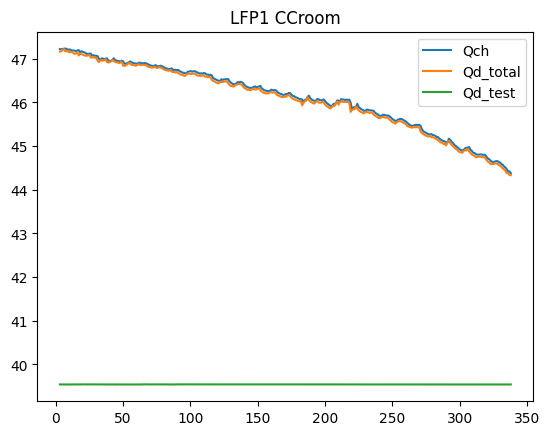

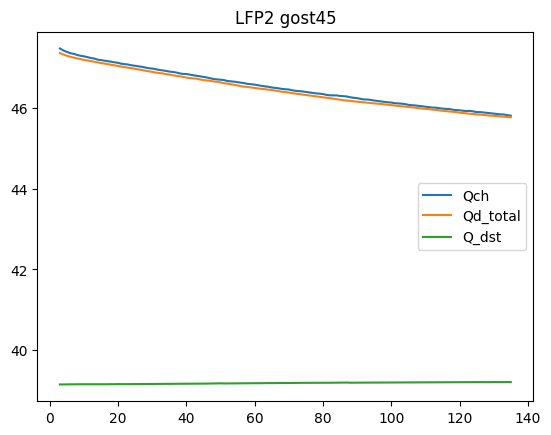

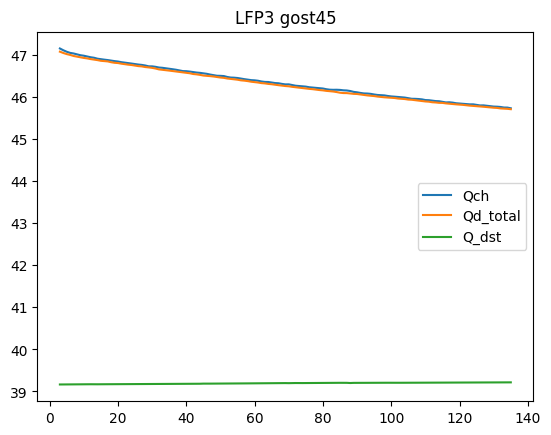

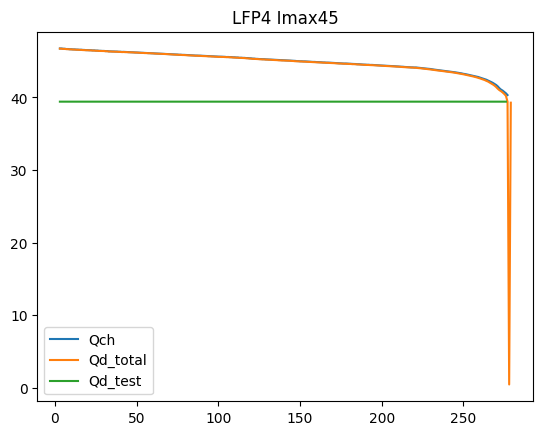

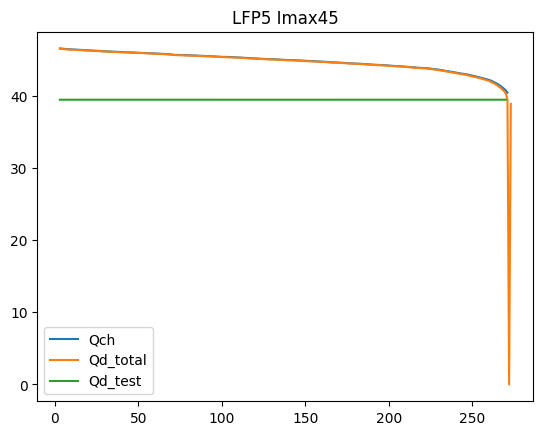

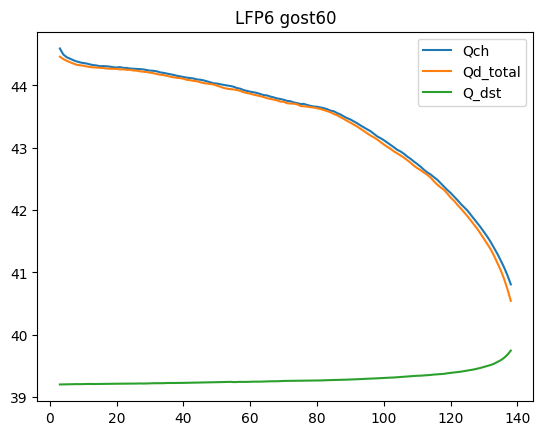

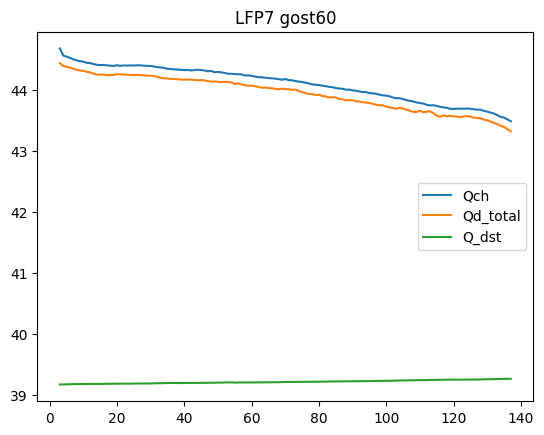

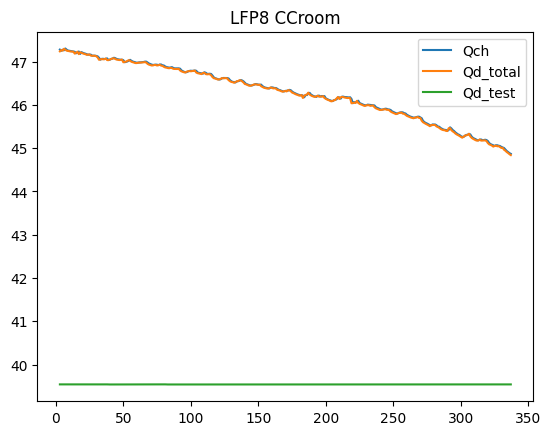

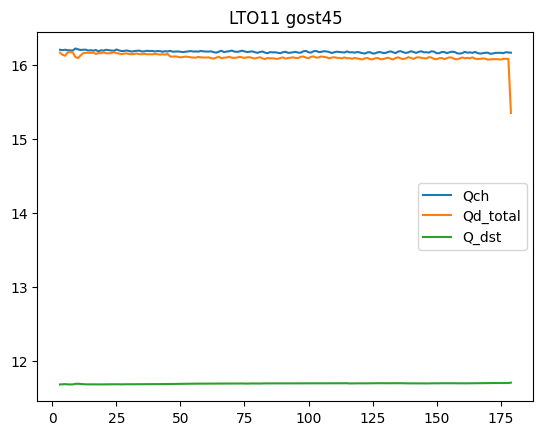

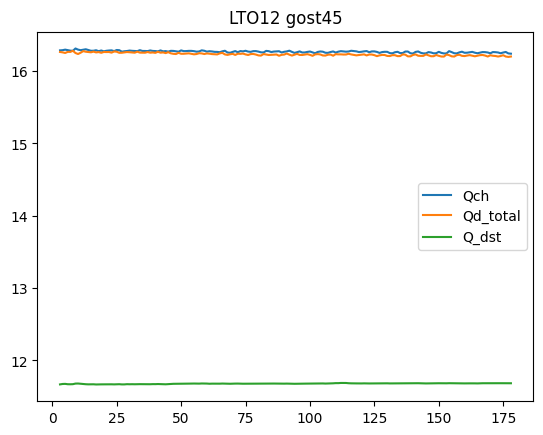

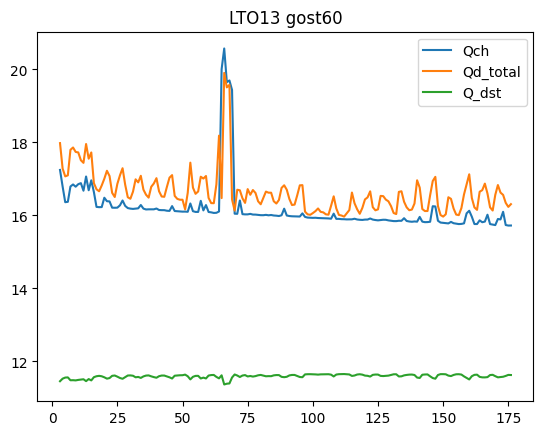

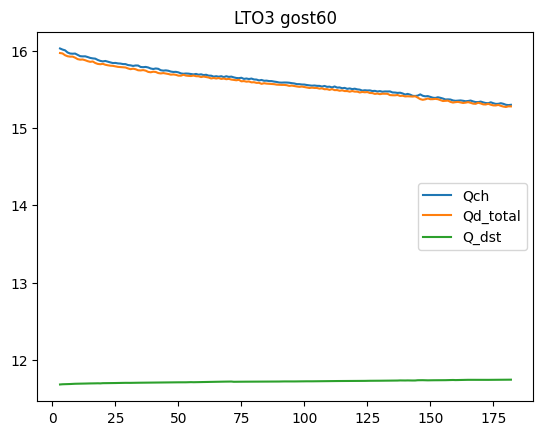

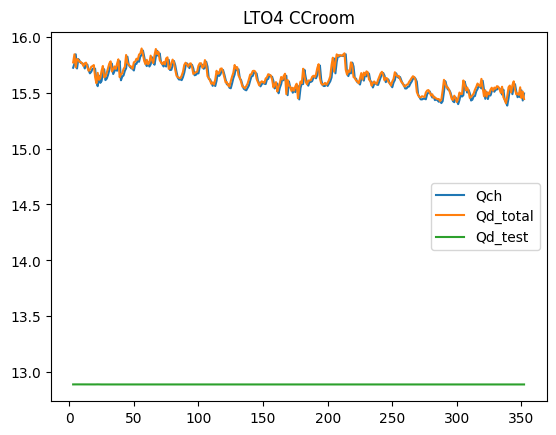

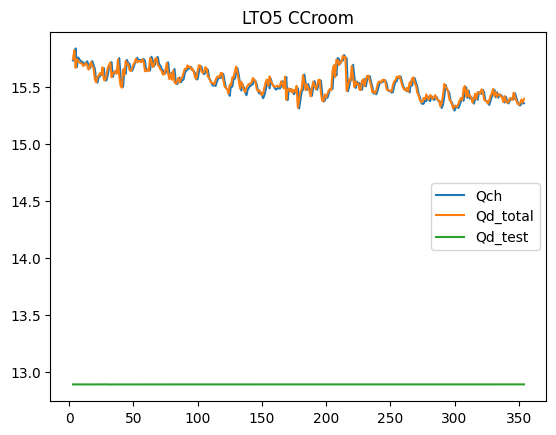

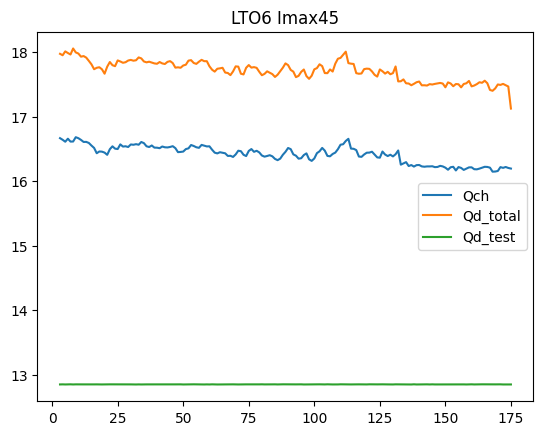

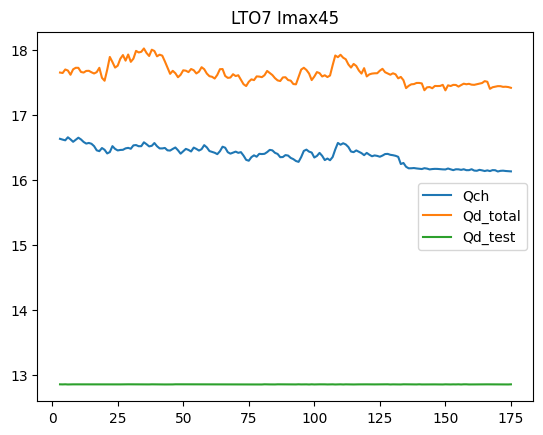

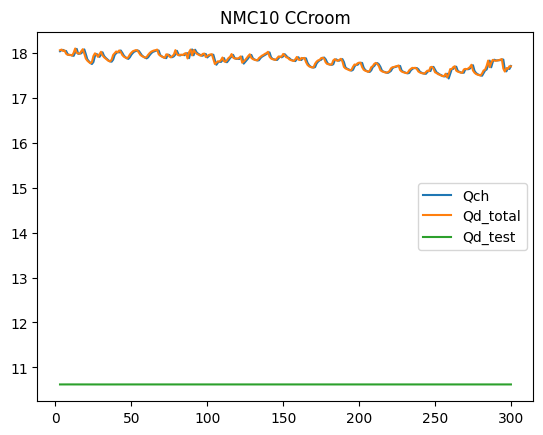

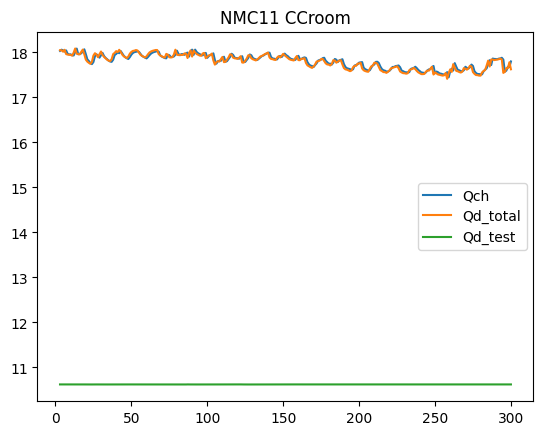

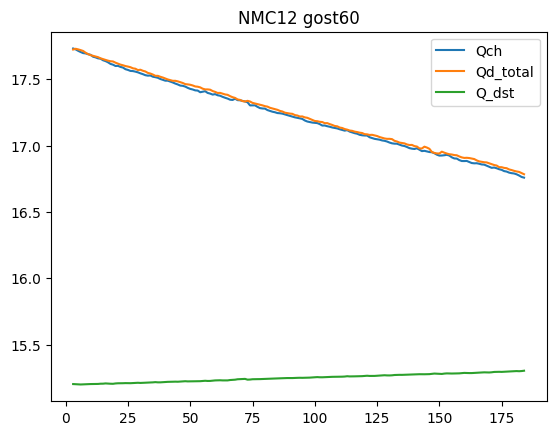

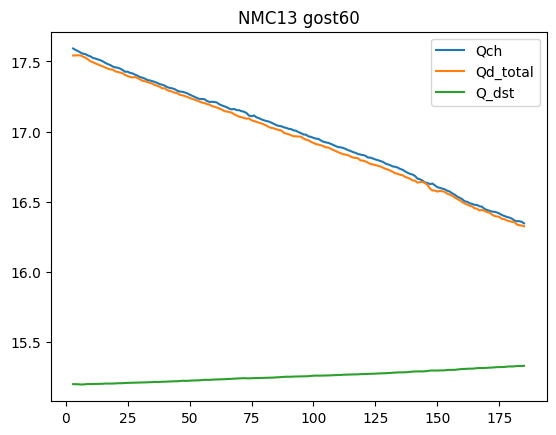

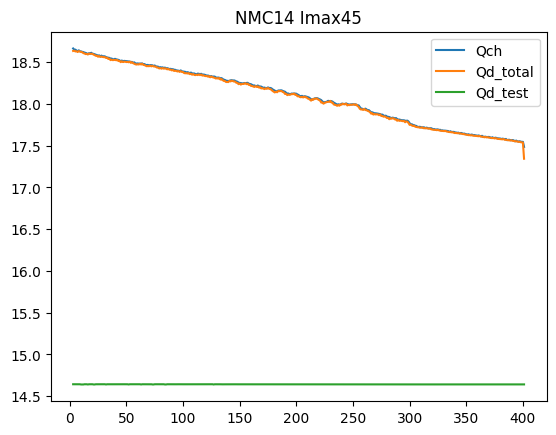

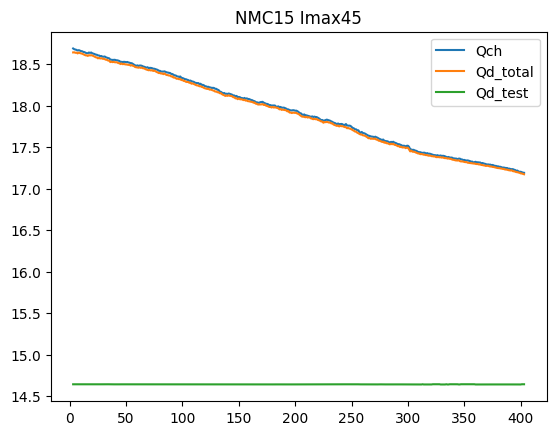

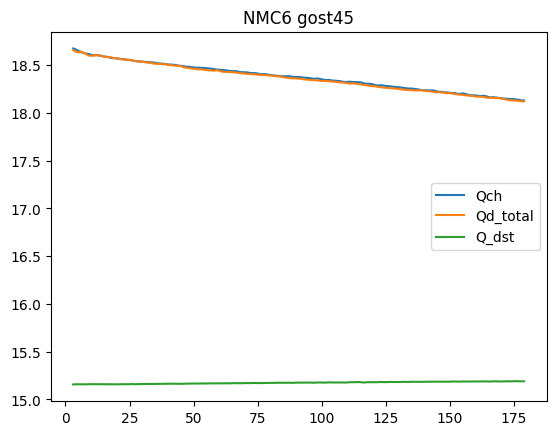

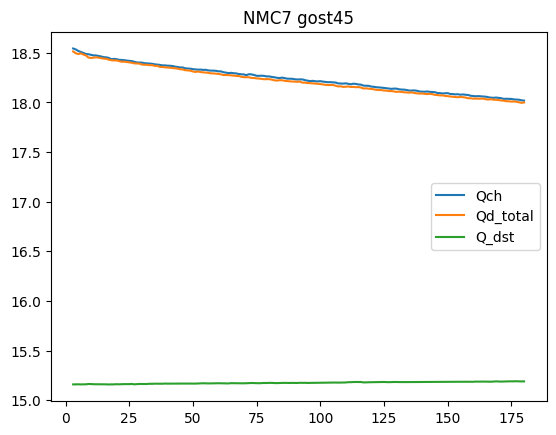

In [16]:
for pouch, cycle in cycling_pouches.items():
    if 'gost' in protocols[pouch]:
        cycle[2:].plot(y=['Qch','Qd_total', 'Q_dst'], title=pouch+' '+protocols[pouch]).figure.savefig(root_dir+fr'\Figures2\{pouch}')
    else:
        cycle[2:].plot(y=['Qch', 'Qd_total', 'Qd_test'], title=pouch+' '+protocols[pouch]).figure.savefig(root_dir+fr'\Figures2\{pouch}')
    bp.exporting.save_experiment(cycle, root_dir+fr'\Обработка 2 циклирования\{pouch}.csv')

In [441]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
changes = step4.select_dtypes(include=numerics).div(step1.select_dtypes(include=numerics)).merge(protocols, left_index=True, right_index=True)

In [18]:
step5 = cycling_results.merge(protocols, left_index=True, right_index=True)



In [352]:
test.columns

Index(['Qdch_dst', 'En_dch_dst', 'Qch_dst', 'En_ch_dst', 'Q_dst', 'n_dst_all',
       'n_dst_b', 'n_dst_a', 'T_mean_dst', 'T_max_dst', 'Qd_total', 'Duration',
       'Q_finishing', 'n_dst_a_before_b', 'E_after_dst'],
      dtype='object')

In [ ]:
test = pd.DataFrame.from_dict(cycling_result1, orient='index')
test.plot(y=['Q_dst'])
test[2:].plot(y=['Q_finishing'])
test[2:].plot(y=['En_ch_dst'])
test[2:].plot(y=['Qch'])
test[2:].plot(y=['T_max_dst'])
test[2:].plot(y=['Qd_total'])


In [402]:

step1 = pd.DataFrame.from_dict(step1_results, orient='index')
step2 = pd.DataFrame.from_dict(step2_results, orient='index')
# step3 = pd.DataFrame.from_dict(step3_results, orient='index').rename(columns=lambda x:x+'_3')
step4 = pd.DataFrame.from_dict(step4_results, orient='index')

In [403]:
step1 = step1.join(protocols)
step2 = step2.join(protocols)

step4 = step4.join(protocols)

In [444]:
bp.exporting.save_experiment(step1, root_dir+fr'\step1.csv')
bp.exporting.save_experiment(step2, root_dir+fr'\step2.csv')
bp.exporting.save_experiment(step3, root_dir+fr'\step3.csv')
bp.exporting.save_experiment(step4, root_dir+fr'\step4.csv')

In [41]:
step3 = cycling_results_stat1
step5 = cycling_results_stat2

In [42]:
bp.exporting.save_experiment(step3, root_dir+fr'\step3.csv')
bp.exporting.save_experiment(step5, root_dir+fr'\step5.csv')

In [43]:
bp.exporting.save_experiment(result_stat, root_dir+fr'\differ2m.csv')